# **1. Consensus atom mapping**

In [1]:
import sys
sys.path.append('../')
from SynTemp.SynAAM.run_consensus import run_consensus_aam
from SynTemp.SynUtils.utils import load_database
folder_name = 'jaworski'
save_dir = f'../Data/{folder_name}'
data = load_database(f'../Data/{folder_name}/{folder_name}_reactions.json.gz')
mapped_reactions = run_consensus_aam(data, save_dir=None, data_name = folder_name, batch_size=50, check_balance=False, verbose=2)

/homes/biertank/tieu/miniconda3/envs/SynITSG/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /homes/biertank/tieu/miniconda3/envs/SynITSG/lib/python3.11/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.decoder.weight', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoi

# **2. ITSG and Rule Extraction**

Assume that you run consensus atom mapping (take time)

## 2.1. Extraction

In [2]:
import sys
sys.path.append('../')
from SynTemp.SynAAM.aam_postprocess import AMMPostprocessor
from SynTemp.SynITS.its_extraction import ITSExtraction
from SynTemp.SynUtils.utils import load_database, save_database

data = load_database(f'../Data/uspto//uspto_balance_aam_reactions.json.gz')
mapper_name = ['rxn_mapper', 'graphormer', 'local_mapper']

# make sure reactions all have atom mapping
check_valid = AMMPostprocessor.parallel_postprocess(data, mapper_name, threshold=3, n_jobs=5, verbose=1)
valid_data = [reaction for reaction in check_valid if reaction.get('Valid')]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 1074 out of 1074 | elapsed:    0.7s finished


In [3]:
# Extract rules and graph rules based on Imaginary Transition State (ITS)
its_graph, its_graph_wrong = ITSExtraction.parallel_process_smiles(valid_data, mapper_name, threshold=2, n_jobs=5, verbose=1, export_full=False, check_method='ITS')

len(its_graph)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 1074 out of 1074 | elapsed:    5.8s finished


1012

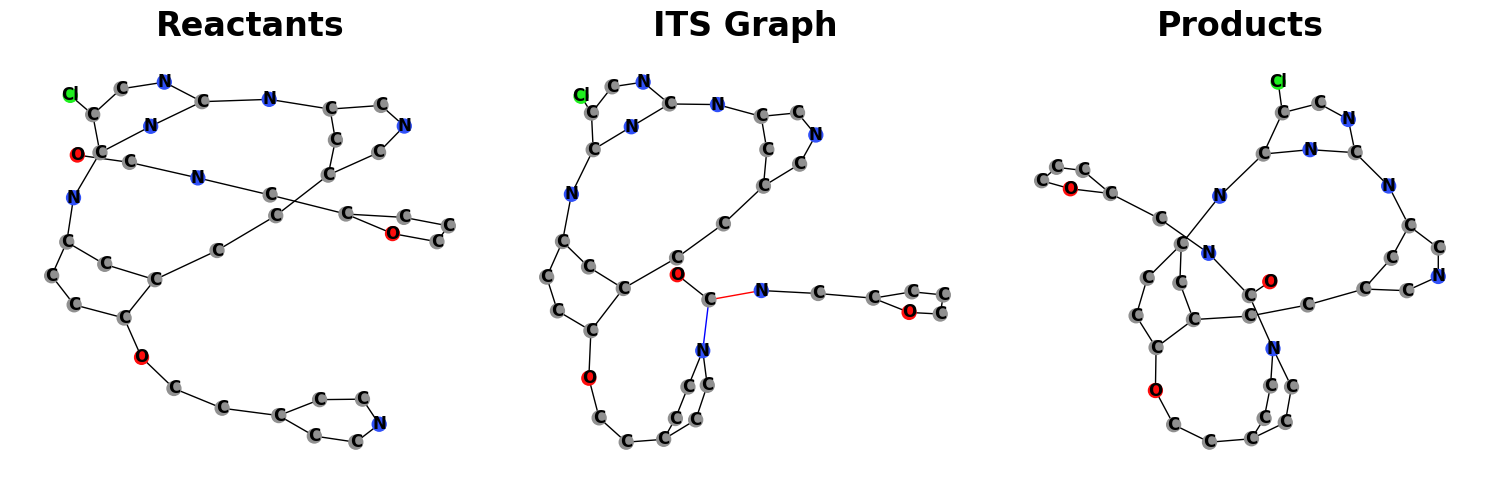

In [4]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer(seed=42)
vis.visualize_all(its_graph[0]['ITSGraph'])

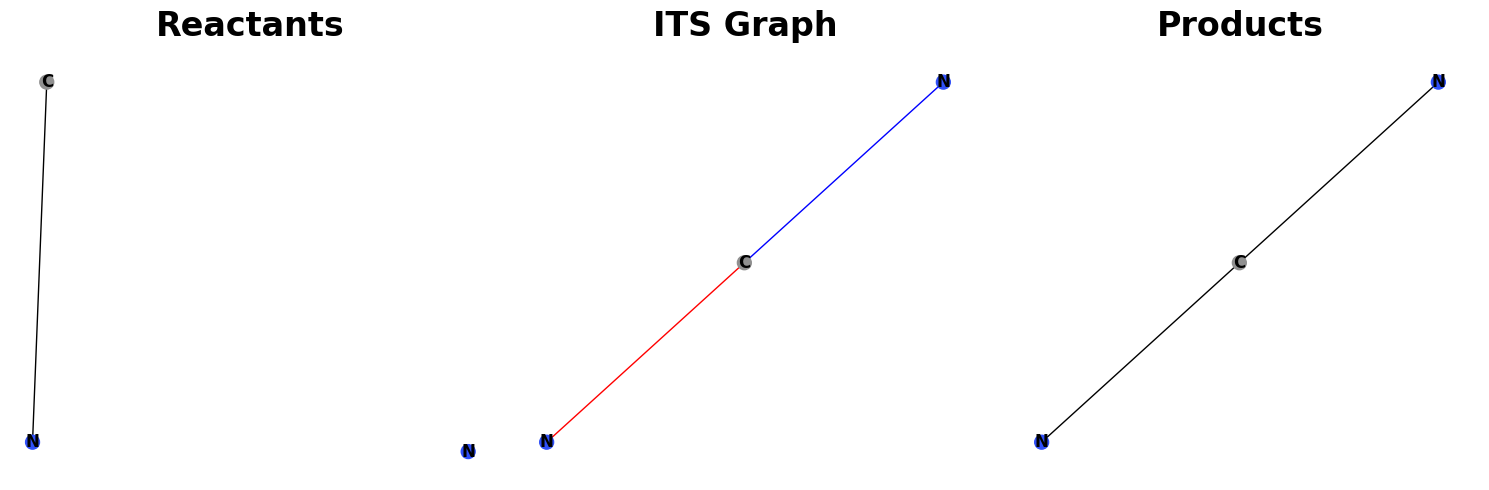

In [5]:
vis = ChemicalGraphVisualizer(seed=42)
vis.visualize_all(its_graph[0]['GraphRules'])

## 2.2. Rules Extension

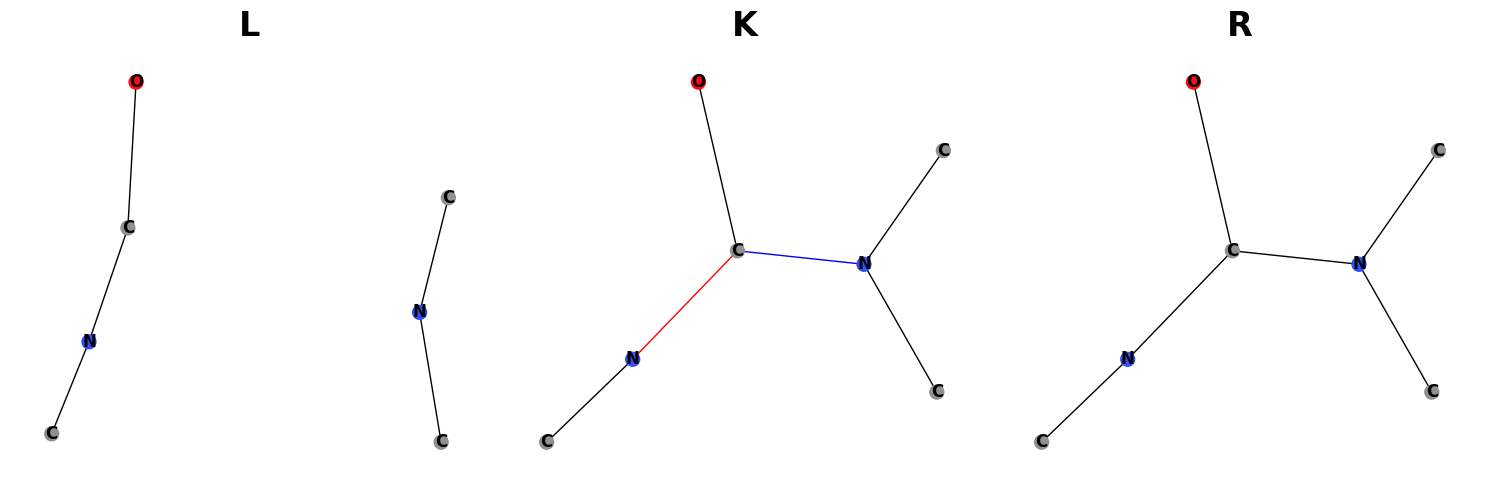

In [6]:
from SynTemp.SynITS.graph_rules_extraction import GraphRuleExtraction
its_graph_rules = GraphRuleExtraction.process_rules_extraction(its_graph, mapper_type='ITSGraph', n_jobs=1, verbose=0, extend=True, n_knn=1)
vis.visualize_all(its_graph_rules[0]['GraphRules'], left_graph_title='L', right_graph_title='R', k_graph_title='K')

# **3. ITS Hydrogen Adjuster**

Make sure ITSG be a cyclic graph

## 3.1. Cyclic ITS Graph

In [7]:
from SynTemp.SynITS.its_hadjuster import ITSHAdjuster

from copy import deepcopy

test_list = deepcopy(its_graph)
print(len(test_list))

process_graph_data = ITSHAdjuster.process_graph_data_parallel(test_list, 'ITSGraph', n_jobs=5, verbose=2)
process_graph_data= [value for _, value in enumerate(process_graph_data) if value['ITSGraph'] is not None]
len(process_graph_data)

1012


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 1012 out of 1012 | elapsed:    1.0s finished


1012

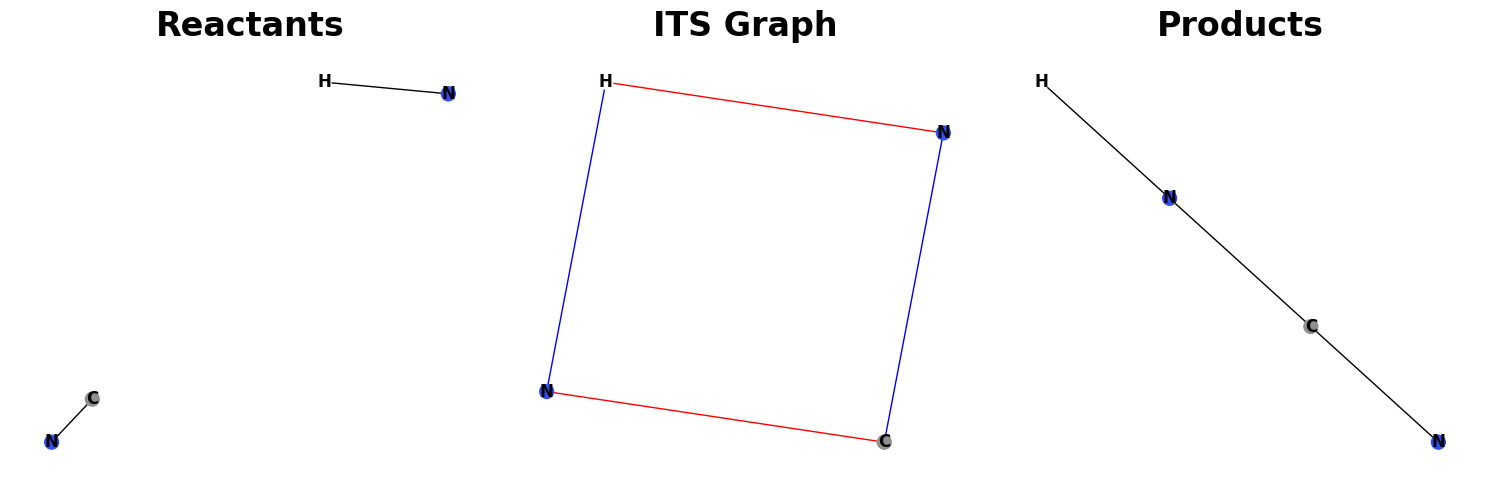

In [8]:
vis.visualize_all(process_graph_data[0]['GraphRules'])

## 2.2. Uncertain atom mapping refinement

In [9]:
from SynTemp.SynITS.uncertain_refinement import UncertainRefinement
from SynTemp.SynUtils.utils import load_from_pickle

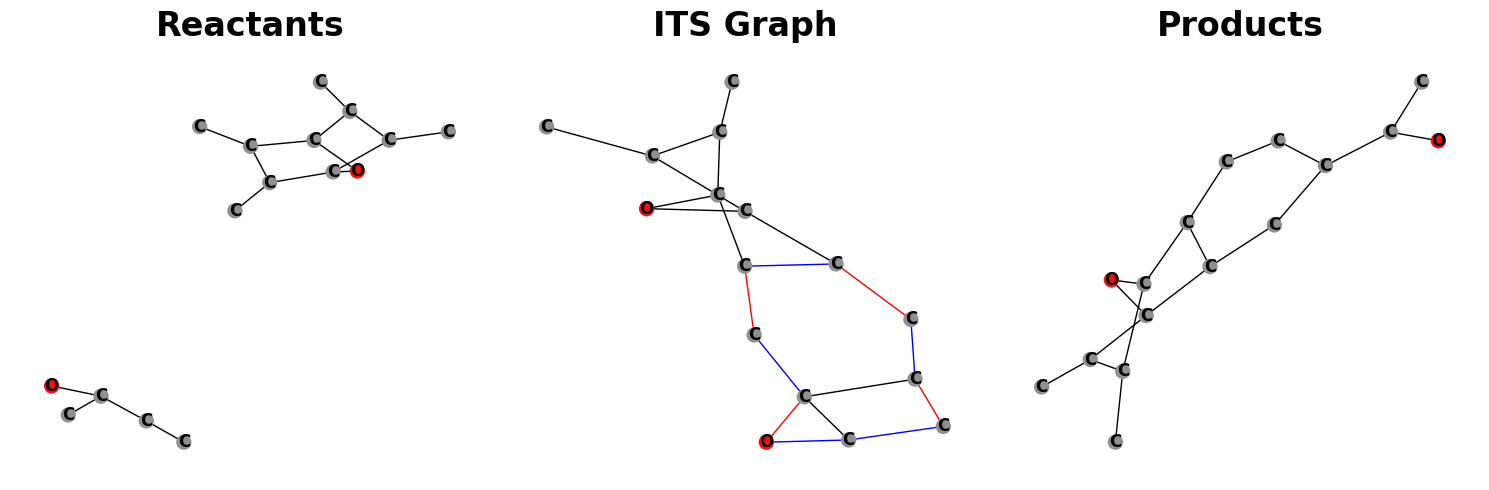

In [12]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer(seed=42)
vis.visualize_all(its_graph_wrong[0]['graphormer'])

In [10]:
process_graphs = UncertainRefinement.process_graphs_in_parallel(its_graph_wrong, n_jobs=1, verbose=1)
print(len(process_graphs))

process_graphs = [value for key, value in enumerate(process_graphs) if value is not None]
print(len(process_graphs))

62
59


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


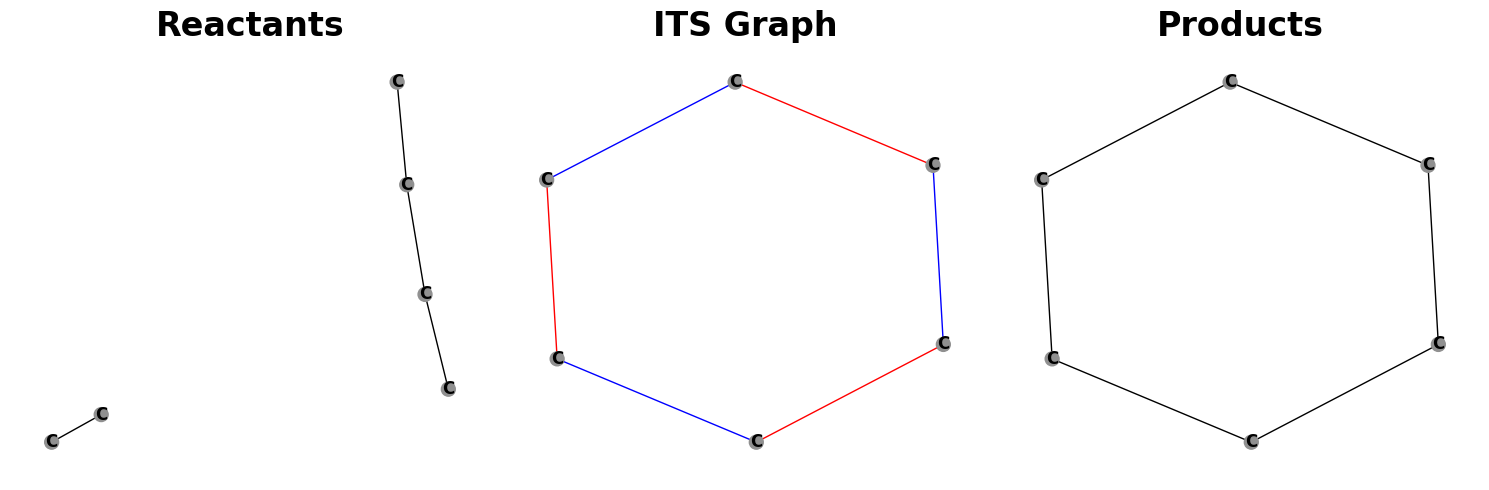

In [11]:
vis.visualize_all(process_graphs[0]['GraphRules'])

# **4. Graph Modelling Language - MØD_rules** 

In [12]:
from SynTemp.SynMØD.MØD_rules import MØDRules
results = MØDRules.auto_extraction(process_graphs, reindex=True, save_path=None, rule_column='GraphRules')
print(results[0])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


rule [
   ruleID "USPTO_50K_31"
   left [
      edge [ source 1 target 2 label "-" ]
      edge [ source 1 target 6 label "=" ]
      edge [ source 2 target 3 label "=" ]
      edge [ source 4 target 5 label "=" ]
   ]
   context [
      node [ id 1 label "C" ]
      node [ id 2 label "C" ]
      node [ id 3 label "C" ]
      node [ id 4 label "C" ]
      node [ id 5 label "C" ]
      node [ id 6 label "C" ]
   ]
   right [
      edge [ source 1 target 2 label "-" ]
      edge [ source 1 target 6 label "-" ]
      edge [ source 2 target 3 label "-" ]
      edge [ source 3 target 4 label "-" ]
      edge [ source 4 target 5 label "-" ]
      edge [ source 5 target 6 label "-" ]
   ]
]


[Parallel(n_jobs=4)]: Done  59 out of  59 | elapsed:    0.7s finished


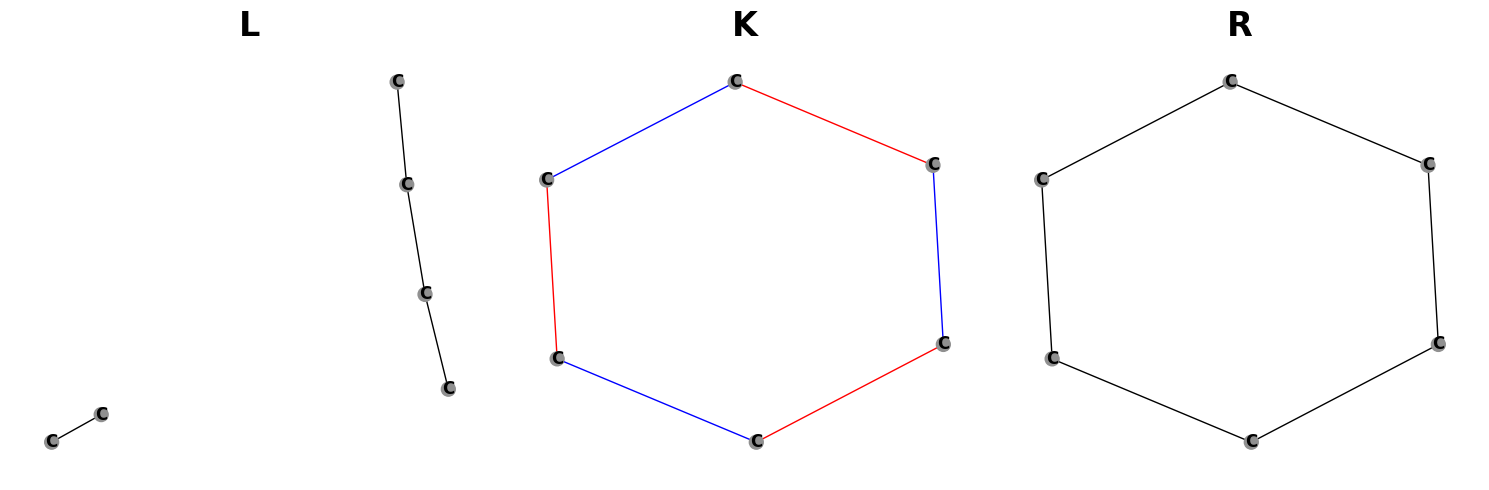

In [13]:
vis.visualize_all(process_graphs[0]['GraphRules'], left_graph_title='L', right_graph_title='R', k_graph_title='K')

# **5. MolToGraph**

In [14]:
from SynTemp.SynUtils.utils import load_database, load_from_pickle
from SynTemp.SynProcessor.mol_to_graph import MolToGraph
from SynTemp.SynProcessor.graph_to_mol import GraphToMol

graph_test = its_graph_rules[0]['GraphRules'][2]

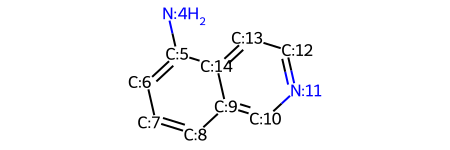

Nodes and their attributes:
[(4, {'charge': 0, 'hcount': 2, 'aromatic': False, 'element': 'N', 'atom_map': 4, 'isomer': 'N', 'partial_charge': -0.398, 'hybridization': 'SP2', 'in_ring': False, 'explicit_valence': 3, 'implicit_hcount': 0}), (5, {'charge': 0, 'hcount': 0, 'aromatic': True, 'element': 'C', 'atom_map': 5, 'isomer': 'N', 'partial_charge': 0.039, 'hybridization': 'SP2', 'in_ring': True, 'explicit_valence': 4, 'implicit_hcount': 0}), (6, {'charge': 0, 'hcount': 1, 'aromatic': True, 'element': 'C', 'atom_map': 6, 'isomer': 'N', 'partial_charge': -0.039, 'hybridization': 'SP2', 'in_ring': True, 'explicit_valence': 4, 'implicit_hcount': 0}), (7, {'charge': 0, 'hcount': 1, 'aromatic': True, 'element': 'C', 'atom_map': 7, 'isomer': 'N', 'partial_charge': -0.06, 'hybridization': 'SP2', 'in_ring': True, 'explicit_valence': 4, 'implicit_hcount': 0}), (8, {'charge': 0, 'hcount': 1, 'aromatic': True, 'element': 'C', 'atom_map': 8, 'isomer': 'N', 'partial_charge': -0.053, 'hybridization

In [15]:
from rdkit import Chem
converter = MolToGraph()
smiles = "[NH2:4][c:5]1[cH:6][cH:7][cH:8][c:9]2[cH:10][n:11][cH:12][cH:13][c:14]12"  
mol = Chem.MolFromSmiles(smiles)
display(mol)
graph = converter.mol_to_graph(mol)

# Display some graph details
print("Nodes and their attributes:")
print(graph.nodes(data=True))
print("\nEdges and their attributes:")
print(graph.edges(data=True))

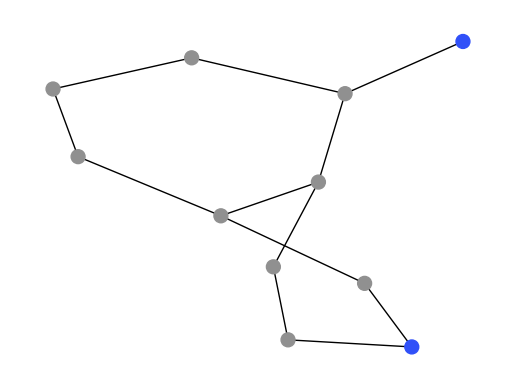

In [16]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer(seed=42)
vis.graph_vis(graph)

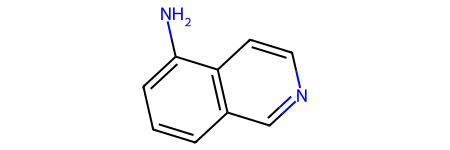

Nc1cccc2cnccc12


In [17]:
node_attributes = {
    'element': 'element',
    'charge': 'charge',
    'atom_atom_map': 'atom_atom_map'
}
edge_attributes = {
    'order': 'order'
}
converter = GraphToMol(node_attributes, edge_attributes)

# Convert graph to RDKit Mol
mol = converter.graph_to_mol(graph)
display(mol)
print(Chem.MolToSmiles(mol))


# **6. Graph Rules alignment**

In [18]:
import sys
sys.path.append('../')
from SynTemp.SynUtils.utils import load_database, load_from_pickle
from SynTemp.SynITS.graph_rules_extraction import GraphRuleExtraction
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer

process_graph_data[0]

{'R-id': 'USPTO_50K_26',
 'ITSGraph': (<networkx.classes.graph.Graph at 0x7f7cfab85f50>,
  <networkx.classes.graph.Graph at 0x7f7cfaae2cd0>),
 'GraphRules': (<networkx.classes.graph.Graph at 0x7f7cfa9d8550>,
  <networkx.classes.graph.Graph at 0x7f7cfa804ad0>)}

In [19]:
from SynTemp.SynITS.graph_rules_extraction import GraphRuleExtraction
from SynTemp.SynMØD.naive_cluster import NaiveCluster
node_label_names=["element", "aromatic", "charge"]
node_label_names=["element", "charge"]
naive_cluster =  NaiveCluster(node_label_names=node_label_names,
                           node_label_default=["*", False, 0], edge_attribute="order")

its_graph_rules_cluster = naive_cluster.process_rules_clustering(process_graph_data, rule_column='GraphRules')
naive = [{'R-id': d['R-id'], 'naive_cluster': d['naive_cluster']} for d in its_graph_rules_cluster]
r_id = [d['R-id'] for d in naive]
its_graph_rules_cluster[0]

{'R-id': 'USPTO_50K_26',
 'ITSGraph': (<networkx.classes.graph.Graph at 0x7f7cfab85f50>,
  <networkx.classes.graph.Graph at 0x7f7cfaae2cd0>),
 'GraphRules': (<networkx.classes.graph.Graph at 0x7f7cfa9d8550>,
  <networkx.classes.graph.Graph at 0x7f7cfa804ad0>),
 'naive_cluster': 0}

In [20]:
import pandas as pd
pd.DataFrame(naive)['naive_cluster'].value_counts()

naive_cluster
0     691
2     107
3      84
1      59
4      41
8       7
10      5
6       4
9       4
5       2
7       2
12      2
14      2
11      1
13      1
Name: count, dtype: int64

In [21]:
from SynTemp.SynUtils.utils import stratified_random_sample
sampled_data = stratified_random_sample(its_graph_rules_cluster, property_key='naive_cluster', samples_per_class=1, seed=42)

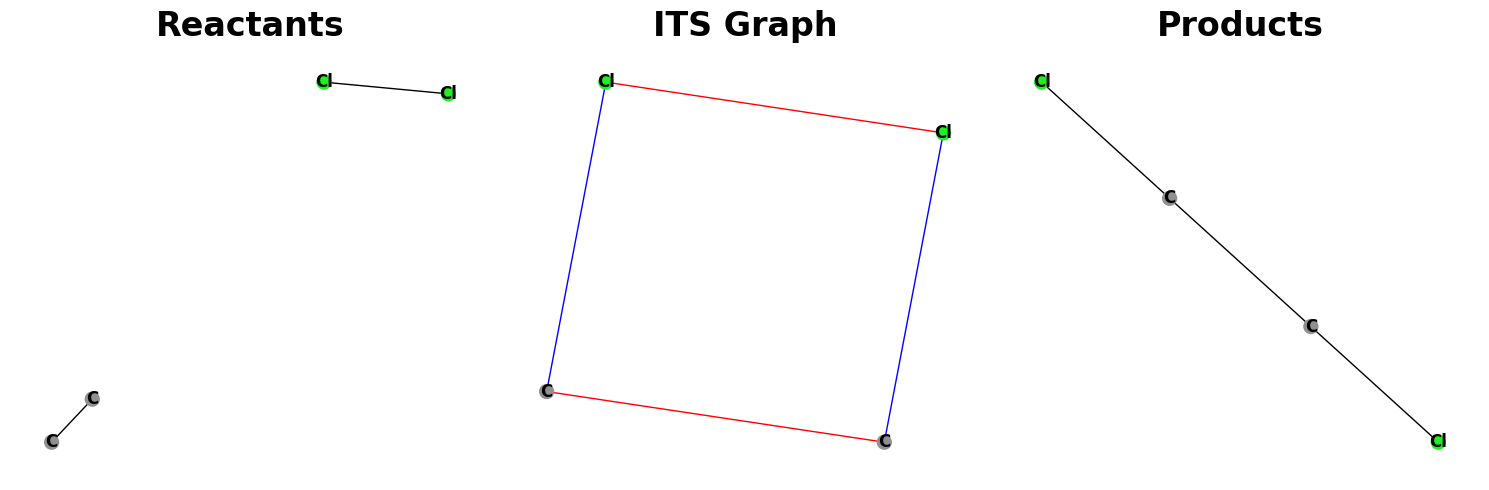

In [22]:
vis.visualize_all(sampled_data[13]['GraphRules'])

# **7. Unbalance reaction**

In [4]:
import sys
sys.path.append('../../')

In [6]:
from SynTemp.SynUtils.utils import load_database
import pandas as pd
unb = load_database('../../Data/jaworski/jaworski_aam_reactions.json.gz')

mapper_name = ['graphormer', 'local_mapper', 'rxn_mapper']

from SynTemp.SynITS.its_extraction import ITSExtraction
correct, incorrect = ITSExtraction.parallel_process_smiles(unb, mapper_name, n_jobs=4, threshold=2)

len(correct), len(incorrect)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Batch computation too fast (0.18318566030058564s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Batch computation too fast (0.038913726806640625s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Batch computation too fast (0.13776111602783203s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Batch computation too fast (0.13513398170471191s.) Setting batch_size=16.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 134 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 154 out of 154 | elapsed:    1.3s finished


(69, 85)

# **8. Arbitrary Hydrogen**

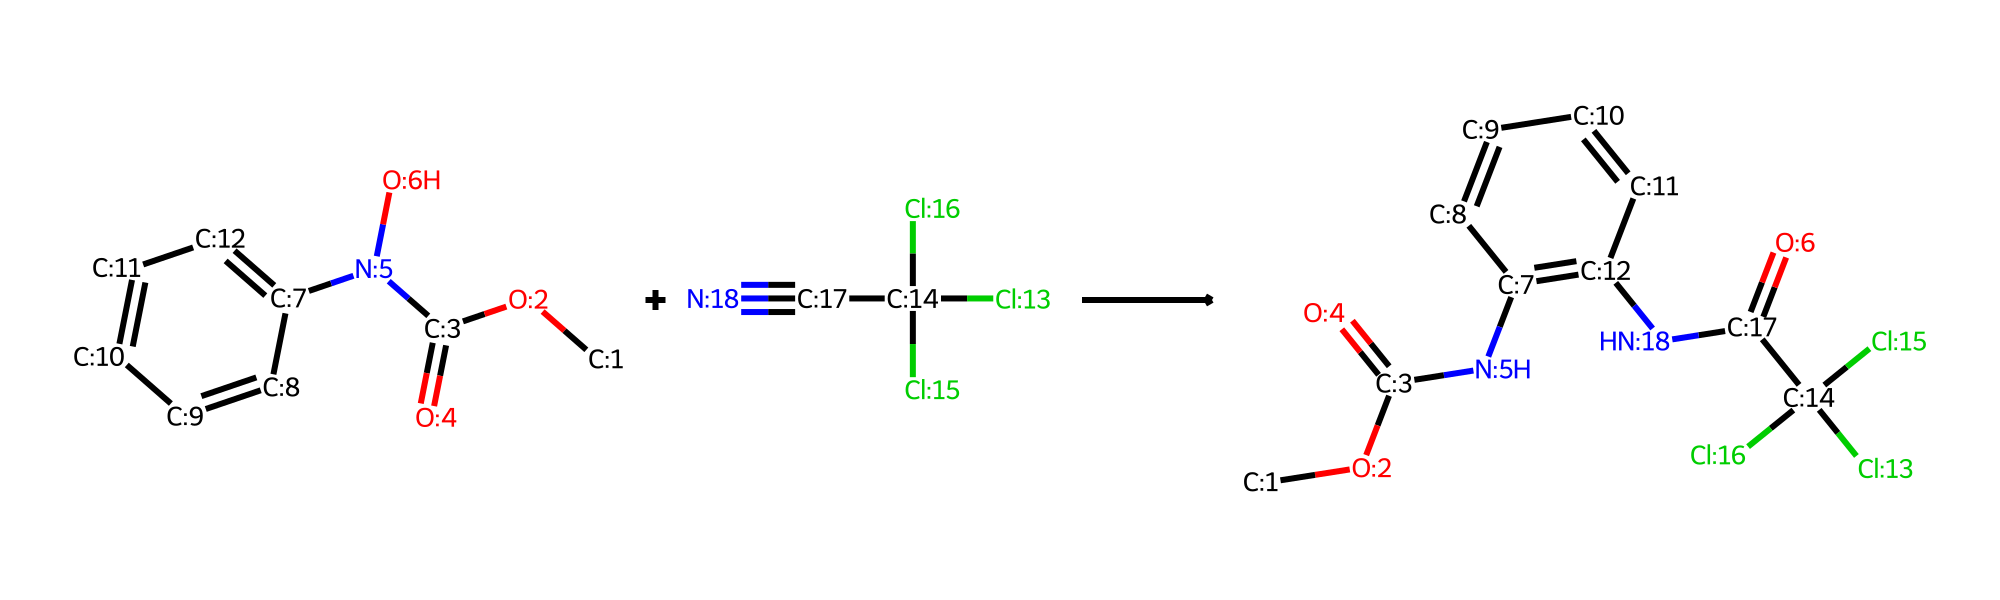

In [24]:
from rdkit import Chem
test = '[CH:10]=1[CH:11]=[CH:12][C:7](=[CH:8][CH:9]=1)[N:5]([OH:6])[C:3](=[O:4])[O:2][CH3:1].[Cl:16][C:14]([Cl:13])([Cl:15])[C:17]#[N:18]>>[Cl:13][C:14]([Cl:16])([Cl:15])[C:17]([NH:18][C:12]=1[C:7](=[CH:8][CH:9]=[CH:10][CH:11]=1)[NH:5][C:3]([O:2][CH3:1])=[O:4])=[O:6]'
from SynTemp.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.visualize_reaction(test)

In [25]:
test_arbitrary = [{'R-id':'C1', 'mapper': test}]
from SynTemp.SynITS.its_extraction import ITSExtraction
mapper_names = ['mapper']
correct, incorrect = ITSExtraction.parallel_process_smiles(test_arbitrary, mapper_names=mapper_names, check_method='RC', threshold=0)
react_graph , product_graph, rule_graph = correct[0]['ITSGraph'][0], correct[0]['ITSGraph'][1], correct[0]['ITSGraph'][2]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s


In [26]:
from SynTemp.SynITS.its_hadjuster import ITSHAdjuster
from SynTemp.SynITS.its_construction import ITSConstruction

variations = ITSHAdjuster.add_hydrogen_nodes_multiple(react_graph, product_graph)
its_list = [ITSConstruction.ITSGraph(i[0], i[1]) for i in variations]

group_1 , group_2 = variations[0] + (its_list[0],), variations[1] + (its_list[1],)
rules_1 = GraphRuleExtraction.extract_reaction_rules(*group_1, extend=False, n_knn=1)
rules_2 = GraphRuleExtraction.extract_reaction_rules(*group_2, extend=False, n_knn=1)

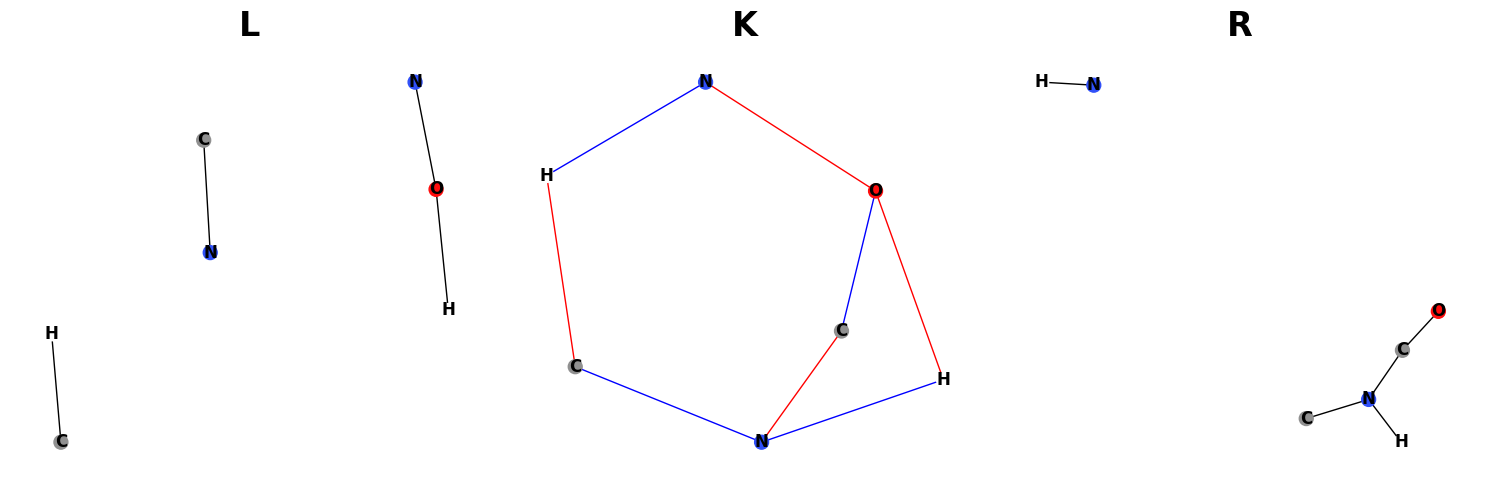

In [28]:
from SynTemp.SynVis.chemical_graph_vis import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer(seed=42)
vis.visualize_all(rules_1, left_graph_title='L', right_graph_title='R', k_graph_title='K')

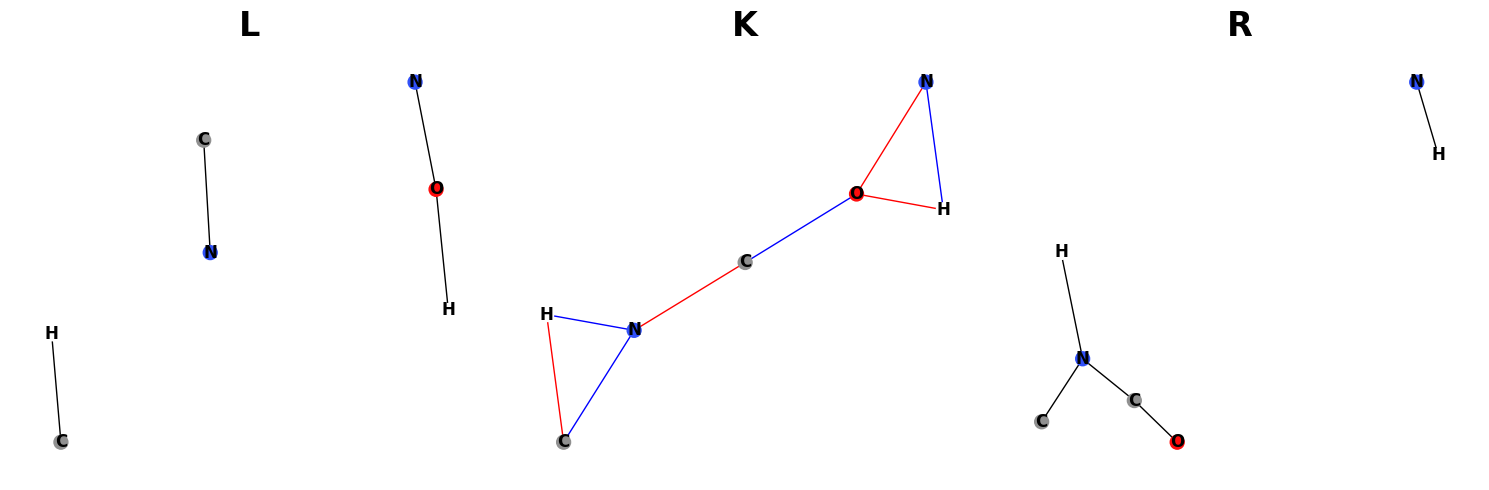

In [29]:
vis.visualize_all(rules_2, left_graph_title='L', right_graph_title='R', k_graph_title='K')